# InferSent - Demonstration

This notebook serves as a demonstration of the usage of a trained InferSent model, as well as training and performance results on the original SNLI task and on SentEval. The notebook also provides some error analysis (discussion) on the results.

## Setup

The notebook assumes the user has access to the pretrained models, logs and evaluation results provided via the [archive.org](https://archive.org) link specified in `README.md`. The notebook also assumes the user has run the `data.py` script with its default arguments such that aligned glove embeddings are available.

First we define our imports

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

from models.infersent import InferSent
import utils

We continue by defining a configuration dictionary that we can access throughout the demo. Of course we can change the values of our config accordingly.

In [2]:
demo_config = {
    # one of 'baseline', 'lstm', 'bilstm', 'maxpoolbilstm'
    "encoder_type": "maxpoolbilstm",
    # path to model checkpoint. by default we load the maxpoolbilstm
    "checkpoint_path": "logs/maxpoolbilstm/version_3/checkpoints/epoch=6-step=60088.ckpt",
    # random seed for reproducibility
    "seed": 42,
    # where to load aligned GloVe torch tensor from
    "aligned_glove": "data/aligned_glove.pt",
}

## Model Loading

We can instantiate the model we will use from the checkpoint path we defined. Because the GloVe embeddings are not saved in the model, after instatiating our model we load them into it in a separate call.

In [3]:
# instantiate pretrained model
model = InferSent.load_from_checkpoint(demo_config["checkpoint_path"])
# load aligned GloVe embeddings from disk
aligned_glove = torch.load(demo_config["aligned_glove"])
# and load them into our model
model.load_embeddings(aligned_glove)

## Inference examples

The InferSent model is trained to perform Natural Language Inference (NLI), i.e. predicting whether a "hypothesis" sentence is true ("entailment"), not true ("contradiction") or neither ("neutral") given a "premise" sentence.

This task is a "proxy" task used for training an encoder sub-model that can be used to embed sentences.

Below, we will first see how we can use the model for performing NLI and then how we can use its encoder to obtain an embedding (vector).

### NLI

Here is our model predicting the entailment between a few pairs of sentences

In [4]:
# first, a quick helper function for printing
def print_entailment_res(premise, hypothesis, result):
    print(f"premise: {premise}")
    print(f"hypothesis: {hypothesis}")
    print(f"model prediction: {result}")
    print("------------\n")


In [5]:
# entailment example from SciTail
premise_1 = "A concave lens is thinner in the middle than it is near its edges."
hypothesis_1 = "A concave lens is thicker at the edges than it is in the middle."
result_1 = model.predict(premise_1, hypothesis_1)
print_entailment_res(premise_1, hypothesis_1, result_1)

# contradiction example from multiNLI
premise_2 = "but that takes too much planning"
hypothesis_2 = "It doesn't take much planning."
result_2 = model.predict(premise_2, hypothesis_2)
print_entailment_res(premise_2, hypothesis_2, result_2)

# neutral example from SciTail
premise_3 = "Energy, heat and/or sound are forms of matter"
hypothesis_3 = "Heat, light, and sound are all different forms of energy."
result_3 = model.predict(premise_3, hypothesis_3)
print_entailment_res(premise_3, hypothesis_3, result_3)

premise: A concave lens is thinner in the middle than it is near its edges.
hypothesis: A concave lens is thicker at the edges than it is in the middle.
model prediction: entailment
------------

premise: but that takes too much planning
hypothesis: It doesn't take much planning.
model prediction: contradiction
------------

premise: Energy, heat and/or sound are forms of matter
hypothesis: Heat, light, and sound are all different forms of energy.
model prediction: neutral
------------



Don't trust that those weren't just hard-coded in the model? Try with some sentences of your own!

In [6]:
# replace these strings and rerun this cell
premise_yours = "Replace this string with your premise."
hypothesis_yours = "Replace this string with your hypothesis."
result_yours = model.predict(premise_yours, hypothesis_yours)

print_entailment_res(premise_yours, hypothesis_yours, result_yours)

premise: Replace this string with your premise.
hypothesis: Replace this string with your hypothesis.
model prediction: neutral
------------



### Sentence Encoding

Here is our model encoding a few sentences. Of course, just embedding a sentence is quite useless if you don't do anything with the embedding afterwards, but this is just a quick demonstration which can be extended.

In [7]:
# first a helper function
def visualize_embedding(sentence, embedding):
    print(embedding)
    plt.figure(figsize=(12, 2))
    plt.title(f"'{sentence}'")
    plt.xlabel("dimension")
    plt.bar(np.arange(len(embedding)), embedding.cpu().numpy())
    plt.tight_layout()
    plt.show()
    print("\n")

tensor([ 0.0513, -0.0105,  0.0309,  ...,  0.0399, -0.0280,  0.1223])


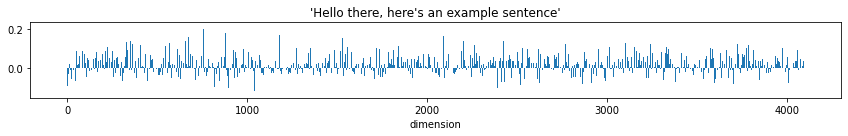



tensor([ 0.0546, -0.0350, -0.0233,  ...,  0.0780,  0.1136, -0.0037])


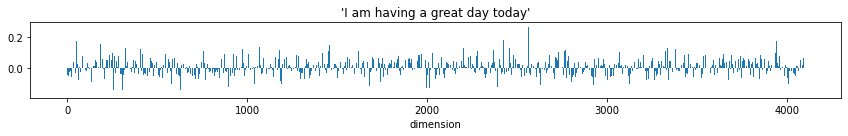



tensor([ 0.0681, -0.0522,  0.0188,  ...,  0.0529,  0.1298,  0.0826])


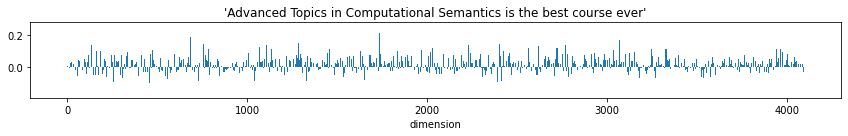

In [8]:
sentence_1 = "Hello there, here's an example sentence"
embedding_1 = model.encoder.encode(sentence_1).squeeze()
visualize_embedding(sentence_1, embedding_1)

sentence_2 = "I am having a great day today"
embedding_2 = model.encoder.encode(sentence_2).squeeze()
visualize_embedding(sentence_2, embedding_2)

sentence_3 = "Advanced Topics in Computational Semantics is the best course ever"
embedding_3 = model.encoder.encode(sentence_3).squeeze()
visualize_embedding(sentence_3, embedding_3)

Try it with your own sentence!

tensor([ 0.0619,  0.0379,  0.0548,  ...,  0.0199, -0.0375,  0.1120])


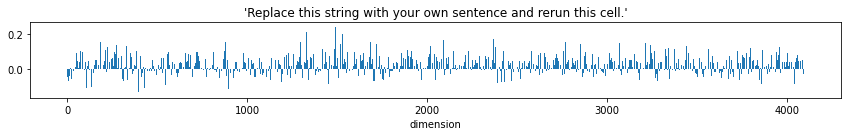

In [9]:
sentence_yours = "Replace this string with your own sentence and rerun this cell."
embedding_yours = model.encoder.encode(sentence_yours).squeeze()
visualize_embedding(sentence_yours, embedding_yours)

## Results

### Training/Validation Loss/Accuracy Curves

Before plotting, I am parsing my tensorboard logs into pandas dataframe

In [10]:
curve_data = {
    "baseline": {
        "path": "logs/baseline/version_6/events.out.tfevents.1650372334.r30n2.lisa.surfsara.nl.31820.0",
        "curves": {},
    },
    "lstm": {
        "path": "logs/lstm/version_5/events.out.tfevents.1650372335.r30n6.lisa.surfsara.nl.8799.0",
        "curves": {},
    },
    "bilstm": {
        "path": "logs/bilstm/version_4/events.out.tfevents.1650373927.r30n2.lisa.surfsara.nl.4844.0",
        "curves": {},
    },
    "maxpoolbilstm": {
        "path": "logs/maxpoolbilstm/version_3/events.out.tfevents.1650380196.r31n5.lisa.surfsara.nl.23051.0",
        "curves": {},
    },
}

In [11]:
for encoder_type in curve_data.keys():
    curve_data[encoder_type]["curves"] = utils.parse_tensorboard(
        curve_data[encoder_type]["path"],
        ["train_loss", "train_acc", "val_loss", "val_acc"],
    )

### Performance Evaluation